In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

bash: line 1: syntax error near unexpected token `newline'
bash: line 1: `<!DOCTYPE html>'


In [28]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from joblib import dump, load
import numpy as np
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
train_data = pd.read_csv("./Prob3/train.csv")
test_data = pd.read_csv("./Prob3/test.csv")

In [42]:
train_data.head()

,Customer_ID,Sign_up_date,Last_order_placed_date,No_of_orders_placed,Maximum_bill,Minimum_bill,No_of_Review_given,No_of_Comment_added,No_of_Images_added,No_of_issues_raised,Orders_returned,Category_of_customers,Gender,Premium,Gift_card_amount
0,ID0x340a,09/22/2012 05:57 AM,12/12/2020 01:01 AM,152,NaN,161.37,76.0,29,NaN,33,4,Active,Female,No,112
1,ID0x547,06/29/2017 08:24 PM,05/01/2019 07:07 AM,59,693.30,101.00,31.0,7,6.0,3,1,Active,Male,No,111
2,ID0x10d1,07/12/2014 06:24 AM,06/17/2015 08:28 AM,77,907.98,217.00,37.0,15,12.0,10,2,Passive,Female,No,37
3,ID0x2395,12/30/2013 03:34 PM,05/12/2018 03:30 AM,337,2406.31,239.43,153.0,40,46.0,50,19,Passive,Male,No,27
4,ID0x1fea,05/29/2015 02:29 AM,07/11/2018 01:18 PM,269,777.26,182.65,93.0,64,16.0,38,6,Passive,Female,Yes,123


In [43]:
# Impute missing values
def missing_value(X):
  X['Category_of_customers'].replace(to_replace=['Active', 'Passive', 'Inactive'], value=[8, 3, 1], inplace=True)
  X['Premium'].replace(to_replace=['Yes', 'No'], value=[9, 1], inplace=True)

  numeric_features = X.select_dtypes(include=['number']).columns.tolist()
  categorical_features = X.select_dtypes(include=['object']).columns.tolist()
  print("categorical_features",categorical_features)
  # Create transformers for preprocessing
  numeric_transformer = SimpleImputer(strategy='median')
  categorical_transformer = SimpleImputer(strategy='most_frequent')

  preprocessor = ColumnTransformer(
      transformers=[
          ('num', numeric_transformer, numeric_features),
          ('cat', categorical_transformer, categorical_features)
      ])

  # Fit and transform on X_train
  X = preprocessor.fit_transform(X)
  X = pd.DataFrame(X, columns=numeric_features + categorical_features)
  return X

In [44]:
train_data = missing_value(train_data)
test_data = missing_value(test_data)

categorical_features ['Customer_ID', 'Sign_up_date', 'Last_order_placed_date', 'Gender']
categorical_features ['Customer_ID', 'Sign_up_date', 'Last_order_placed_date', 'Gender']


In [45]:
y = train_data["Gift_card_amount"]

In [46]:
train_data.head()

,No_of_orders_placed,Maximum_bill,Minimum_bill,No_of_Review_given,No_of_Comment_added,No_of_Images_added,No_of_issues_raised,Orders_returned,Category_of_customers,Premium,Gift_card_amount,Customer_ID,Sign_up_date,Last_order_placed_date,Gender
0,152.0,723.89,161.37,76.0,29.0,8.0,33.0,4.0,8.0,1.0,112.0,ID0x340a,09/22/2012 05:57 AM,12/12/2020 01:01 AM,Female
1,59.0,693.3,101.0,31.0,7.0,6.0,3.0,1.0,8.0,1.0,111.0,ID0x547,06/29/2017 08:24 PM,05/01/2019 07:07 AM,Male
2,77.0,907.98,217.0,37.0,15.0,12.0,10.0,2.0,3.0,1.0,37.0,ID0x10d1,07/12/2014 06:24 AM,06/17/2015 08:28 AM,Female
3,337.0,2406.31,239.43,153.0,40.0,46.0,50.0,19.0,3.0,1.0,27.0,ID0x2395,12/30/2013 03:34 PM,05/12/2018 03:30 AM,Male
4,269.0,777.26,182.65,93.0,64.0,16.0,38.0,6.0,3.0,9.0,123.0,ID0x1fea,05/29/2015 02:29 AM,07/11/2018 01:18 PM,Female


In [47]:

#Data preprocessing
def preprocess_data(data):
    data['Last_order_placed_date'] = pd.to_datetime(data['Last_order_placed_date'])

    data['LastOrder_DayofWeek'] = data['Last_order_placed_date'].dt.dayofweek

    data['Sign_up_date'] = pd.to_datetime(data['Sign_up_date'])
    data['Last_order_placed_date'] = pd.to_datetime(data['Last_order_placed_date'])
    data['signup_dayofweek'] = data['Sign_up_date'].dt.dayofweek
    data['signup_month'] = data['Sign_up_date'].dt.month
    data['signup_quarter'] = data['Sign_up_date'].dt.quarter
    data['signup_year'] = data['Sign_up_date'].dt.year

    data['signup_to_last_order_duration'] = (data['Last_order_placed_date'] - data['Sign_up_date']).dt.days

    agg_cols = ['No_of_orders_placed', 'Maximum_bill', 'Minimum_bill', 'No_of_Review_given', 'No_of_Comment_added', 'No_of_issues_raised', 'Orders_returned']
    data['mean_orders'] = (data.groupby('Customer_ID')['No_of_orders_placed'].transform('median'))*2.5
    data['median_review'] = data.groupby('Customer_ID')['No_of_Review_given'].transform('median')
    data['return_ratio'] = data['Orders_returned'] / data['No_of_orders_placed']
    avg = abs(data['Maximum_bill']+data['Minimum_bill'])/2
    data['f1'] = (data['No_of_orders_placed'] * avg)*10
    data['f3'] = data['No_of_orders_placed'] - data['Orders_returned']
    data['f4'] = data['f3']* avg
    data['f5'] = (data.groupby('Customer_ID')['f4'].transform('mean') + data['Premium'])*10


    # Calculate differences
    data['Days_difference'] = (data['Last_order_placed_date'] - data['Sign_up_date']).dt.days
    data['Months_difference'] = ((data['Last_order_placed_date'] - data['Sign_up_date']).dt.days) // 30
    data['Years_difference'] = ((data['Last_order_placed_date'] - data['Sign_up_date']).dt.days) // 365


    data['Bill_difference'] = data['Maximum_bill'] - data['Minimum_bill']

    data['Total_review_score'] = (data['No_of_Review_given'] + data['No_of_Comment_added'] + data['No_of_Images_added'])



    data['Review_ratio'] = (data['Total_review_score'] / data['No_of_orders_placed'])*2.5
    data['Return_ratio'] = data['Orders_returned'] / data['No_of_orders_placed']
    data['Issue_ratio'] = data['No_of_issues_raised'] / data['No_of_orders_placed']

    data['Reviews_per_order'] = data['No_of_Review_given'] / data['No_of_orders_placed']

    data['Total_engagement'] = (
        data['No_of_Review_given'] +
        data['No_of_Comment_added'] +
        data['No_of_Images_added'] +
        data['No_of_issues_raised']
    )

    # Create a new feature
    data['Engagement_per_order'] = (
        data['Total_engagement'] / data['No_of_orders_placed']
    )*5

    data['No_of_orders_placed'] = data['No_of_orders_placed']*10
    data['Orders_returned'] = data['Orders_returned']*1.5
    data['num_words_in_reviews'] = data['No_of_Review_given'].apply(lambda x: len(str(x).split()))
    return data


In [48]:
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

In [49]:
def scale(df, features):
  std_scaler = StandardScaler()

  df_scaled = std_scaler.fit_transform(df.to_numpy())
  df_scaled = pd.DataFrame(df_scaled, columns=features)
  return df_scaled

In [50]:
# Feature selection
features = ['LastOrder_DayofWeek','signup_dayofweek','signup_month','signup_quarter','signup_year','No_of_orders_placed', 'Maximum_bill', 'Minimum_bill',
            'No_of_Review_given', 'No_of_Comment_added', 'No_of_issues_raised', 'Orders_returned',
            'mean_orders','median_review','return_ratio','f1','Category_of_customers',
            'No_of_Images_added','Premium','f3','f4','f5','Days_difference','Months_difference','Years_difference','Bill_difference','Total_review_score',
            'Review_ratio', 'Return_ratio', 'Issue_ratio', 'Reviews_per_order', 'Engagement_per_order']


X = train_data[features]
# X = scale(train_data[features], features)


test_cust_label = test_data['Customer_ID']
test_data = test_data[features]
# test_data = scale(test_data[features], features)

y = train_data['Gift_card_amount']

le = LabelEncoder()

**Apply corelation matrix to select the feature**

In [127]:
# debug       = 1 # 1-enable Debug Prints/Messages
# def correlation(dataset, threshold):
#   # Captures all Columns to be Removed based on threshold
#   col_corr = set()
#   cor_mat = dataset.corr()

#   # Plot a heatmap of the correlation matrix
#   plt.figure(figsize=(12, 10))
#   sns.heatmap(cor_mat, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
#   plt.title('Correlation Matrix')
#   plt.show()

#   for i in range(len(cor_mat.columns)):
#       for j in range(i):
#           if (cor_mat.iloc[i, j] >= threshold) and (cor_mat.columns[j] not in col_corr):
#               colname = cor_mat.columns[i] # getting the name of column
#               col_corr.add(colname)
#               if colname in dataset.columns:
#                   del dataset[colname] # deleting the column from the dataset

#   if (len(col_corr) != 0):
#     print('These {} columns were removed based on Data Correlation'.format(col_corr))
#   return dataset

# ## Find Data Correlation
# corrData_train = correlation(X.drop(['Category_of_customers','Premium'], axis=1), 0.95)
# corrData_test = correlation(test_data.drop(['Category_of_customers','Premium'], axis=1), 0.95)


# if (debug):
#   print('\nTrain data without Correlated features..')
#   display(corrData_train)

In [128]:
# corrData_train.head()

In [129]:
# corrData_train['Maximum_bill'][:10]

<Axes: >

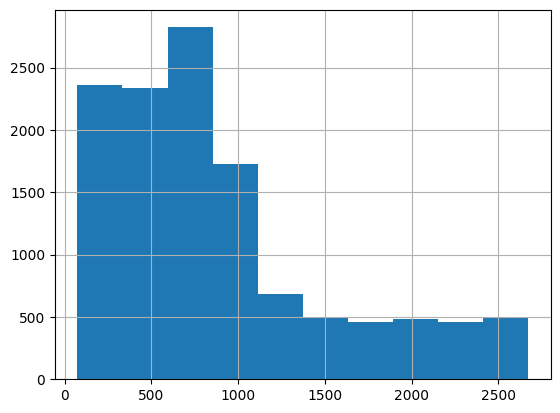

In [ ]:
corrData_train['Maximum_bill'].hist()

In [51]:
# Train-test split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.14, random_state=42)



X_t, X_v, y_t, y_v = train_test_split(X, y, test_size=0.14, random_state=42)

In [21]:
from sklearn.ensemble import RandomForestRegressor
import joblib
from pprint import pprint
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
import time
import pytz
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [52]:
def impFeat(model, X_):
  print('Plotting the Important features..')
  impFeatures = model.best_estimator_.feature_importances_
  indices = np.argsort(impFeatures)
  plt.yticks(range(len(indices)), [X_.columns[i] for i in indices])
  plt.barh(range(len(indices)), impFeatures[indices], color='r', align='center')
  plt.show()
  return 0

## Print Model Result
def print_result(model, results):
  print('Model: {} / BEST PARAMS: {}'.format(model, results.best_params_))

  if (debug): display(results.cv_results_)

  means = results.cv_results_['mean_test_score']
  stds  = results.cv_results_['std_test_score']

  for mean, std, params in zip(means, stds, results.cv_results_['params']):
    print('{} (+/-{}) for {}'.format(round(mean, 2), round(std * 2, 3), params))

  return 0

def selBestFeat(model, xTr, yTr, r_v):
  if (r_v):
    # Select the best features according to Recursive Feature Elimination (RFE)
    sel = RFE(model, n_features_to_select=15)
    sel.fit(xTr, yTr)

    selected_features = list(xTr.columns[sel.support_])
    print("Feature selection", sel.support_)
    print("Feature ranking", sel.ranking_)
    print("Selected features:", selected_features)
    print("Removed features:", list(xTr.columns[~sel.support_]))
  else:
    sel = VarianceThreshold(threshold=(0.05))
    sel.fit(xTr)

    selected_features = list(xTr.columns[sel.get_support()])
    print("Feature selection", sel.get_support())
    print("Selected features:", selected_features)
    print("Removed features:", list(xTr.columns[~sel.get_support()]))

  ## Transform (remove low variance features)
  ## Next Step is to return new Train
  rTrain = sel.transform(xTr)
  ## Remember to remove same features from Test Set as well
  ## rTest = sel.transform(xTe)

  ## return rTrain, rTest
  return 0


def RandomForestRegr(X, y, featSel=0, c_r=0, gs_rs=0, r_v=1, rndmSt=42):
  """
  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
  """
  ## Instantiate Random Forest Regressor and tune Hyper-parameters.
  rfParams = {
      'n_estimators'  : [int(x) for x in np.linspace(start = 450, stop = 480, num = 6)], ## No of trees in Forest
      'max_depth'     : [6,8,1], ## Max number of levels in each decision tree
      'random_state'  : [rndmSt]
  }

  pprint(rfParams)
  rndFrst = RandomForestRegressor()

  if (featSel):
    selBestFeat(rndFrst, X, y, r_v)

  if (gs_rs):
    rfGsCv = GridSearchCV(rndFrst, rfParams, cv=5, n_jobs=-1, scoring="neg_mean_squared_error")
  else:
    ##n_iter is number of different combinations to try; cv number of folds to use for cross validation.
    rfRsCv = RandomizedSearchCV(rndFrst, rfParams, n_iter=25, cv=5, n_jobs=-1, random_state=0, scoring="neg_mean_squared_error")

  strTime  = time.time()
  ## Training..
  if (gs_rs):
    rfCvFit = rfGsCv.fit(X, y)
  else:
    rfCvFit = rfRsCv.fit(X, y)

  rfCvFit.best_params_

  endTime  = time.time()
  predTime = (endTime - strTime)

  print('Random Forest Regression --> Time to Train: {}'.format(time.strftime("%H:%M:%S", time.gmtime(round(predTime)))))
  print_result("Random_Forest_Regressor", rfCvFit)

  impFeat(rfCvFit, X) ## Display important features

  ## Write out Pickled Model
  joblib.dump(rfCvFit.best_estimator_, 'RFR_Model.pkl')
  if (gs_rs):
    return rfGsCv
  else:
    return rfRsCv

def evaluateModel(c_r, name, model, features, labels):
  ## Prediction
  predicts   = model.predict(features)

  if (c_r):
    accuracy  = round(accuracy_score(labels, predicts), 3)
    precision = round(precision_score(labels, predicts), 3)
    recall    = round(recall_score(labels, predicts), 3)
    print('Accuracy: {}, Precision: {}, Recall: {}'.format(accuracy, precision, recall))
    print(classification_report(labels, predicts)) #, target_names=labels.index
    score = 100 * accuracy # Competitions Evaluation Method..
  else:
    score = 100*(max(0 , r2_score(labels, predicts)))

  print('R2 Score of {} is {}'.format(name, np.where(c_r, score, round(score, 4))))

  return score


def predictModel(name, model, features, ix, lbl):
  ## Prediction
  predicts = model.predict(features)

  print('Predicting with {}\n'.format(name))

  pred = np.around(predicts, decimals=0)

  sub  = pd.DataFrame(pred, columns=[lbl])
  if (ix != None):
    sub.index = features.index
    Tr_Fl     = True
  else:
    Tr_Fl     = False

  display(sub)

  sub.to_csv('sample_submission.csv', index=Tr_Fl)
  return 0



## Start Defining Functions here..
def timedisplay():
  indTZ = pytz.timezone("Asia/Calcutta")
  ## print(indTZ)
  timeinIndia = datetime.now(indTZ)

  currTimeInd = timeinIndia.strftime("%H:%M:%S")
  return currTimeInd



Starting GridSearch

Training RFR to determine Best Params.
{'max_depth': [6, 8, 1],
 'n_estimators': [450, 456, 462, 468, 474, 480],
 'random_state': [42]}
Random Forest Regression --> Time to Train: 00:37:40
Model: Random_Forest_Regressor / BEST PARAMS: {'max_depth': 8, 'n_estimators': 480, 'random_state': 42}
-378.76 (+/-18.493) for {'max_depth': 6, 'n_estimators': 450, 'random_state': 42}
-378.74 (+/-18.473) for {'max_depth': 6, 'n_estimators': 456, 'random_state': 42}
-378.74 (+/-18.458) for {'max_depth': 6, 'n_estimators': 462, 'random_state': 42}
-378.75 (+/-18.485) for {'max_depth': 6, 'n_estimators': 468, 'random_state': 42}
-378.74 (+/-18.504) for {'max_depth': 6, 'n_estimators': 474, 'random_state': 42}
-378.73 (+/-18.5) for {'max_depth': 6, 'n_estimators': 480, 'random_state': 42}
-371.03 (+/-6.258) for {'max_depth': 8, 'n_estimators': 450, 'random_state': 42}
-371.0 (+/-6.281) for {'max_depth': 8, 'n_estimators': 456, 'random_state': 42}
-371.0 (+/-6.306) for {'max_depth'

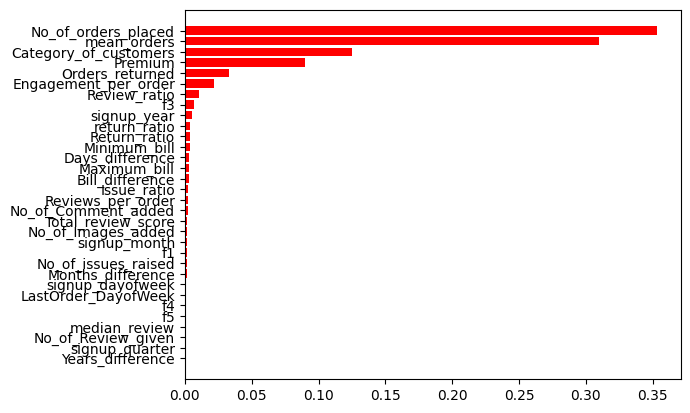


GridSearch:: Evaluating RFR to find if its better than rest.
R2 Score of RFR is 74.9462

GridSearch:: Best Model found is RFR, Model RandomForestRegressor(max_depth=8, n_estimators=480, random_state=42), with Score 74.94619270688544

GridSearch:: Model RFR has best score 74.94619270688544

Predicting with RFR



,Gift_card_amount
0,46.0
1,47.0
2,75.0
3,54.0
4,50.0
...,...
3075,48.0
3076,49.0
3077,49.0
3078,109.0



toImpute: 0, mean_drop: 1, scale: 0, class_regr: 0, shuffle: True, scaleType: 0, randomSeed: 42, train_test_split: 0.14

End Time - 23:14:29 : Completed Predicting Gift Card Amount in 00:37:42..


In [53]:
from sklearn.ensemble import RandomForestRegressor
import joblib
from pprint import pprint
idx             = "Customer_ID"
labels          = 'Gift_card_amount'
train_test_splt = 0.14
## To maintain consistency between Train and Test Dataset, assign values to variables here.
debug       = 0 # 1-enable Debug Prints/Messages
toImpute    = 0 # 1-Impute; 0-No Imputation
mean_drop   = 1 # 1-Mean; 0-Drop Rows
scale       = 0 # 1-Scaling , 0-No Scaling
class_regr  = 0 # 1-Classification, 0-Regression
Shuffle     = True # True-Shuffle train-test split data, False-Do not shuffle
votingRegr  = 0
scaleType   = 0  # 0-Standard; 1-MinMax
rfe_var     = 1  # 1-RFE, 0-VAR
randomSeed  = 42 # Integer or None

############################## Search Types ####################################
##SearchType = ['RandomSearch','GridSearch']
SearchType = ['GridSearch']
pgmStrtTime = time.time()
for srch in SearchType:
  print('\nStarting {}'.format(srch))
  Models = ['RFR']

  for mdl in Models:
    print('\nTraining {} to determine Best Params.'.format(mdl))
    rfVR  = RandomForestRegr(X_t, y_t, np.where(scale, 1, 0), np.where(class_regr, 1, 0), np.where(srch == 'GridSearch', 1, 0), rfe_var, randomSeed)

		## Now that we have Best Model for each Algorithms, let's use them on Validation and Test
		## Read in Models
    models = {}
    for mdl in Models:
      models[mdl] = joblib.load('{}_Model.pkl'.format(mdl))
      if (debug): display(models)

    scores = {}
    ## Find Best Model among Best Models
    for name, mdl in models.items():
      print('\n{}:: Evaluating {} to find if its better than rest.'.format(srch, name))
      score = evaluateModel(class_regr, name, mdl, X_v, y_v)
      scores[name] = {"Model": mdl, "Score": score}
      if (debug): display(scores)

    ## Use the Best Model based on score
    flg = 0
    for name, score in scores.items():
      if (flg == 0):
          bestScore = score['Score']
          bestModel = score['Model']
          modelName = name
          flg = 1
      else:
        if (score['Score'] > bestScore):
          bestScore = score['Score']
          bestModel = score['Model']
          modelName = name

    print('\n{}:: Best Model found is {}, Model {}, with Score {}'.format(srch, modelName, bestModel, bestScore))

		## Finally Evaluate on Test Set, based on Best Model above
    print('\n{}:: Model {} has best score {}\n'.format(srch, modelName, bestScore))
    predictModel(modelName, bestModel, test_data, idx, labels)

pgmEndTime = time.time()

print('\ntoImpute: {}, mean_drop: {}, scale: {}, class_regr: {}, shuffle: {}, scaleType: {}, randomSeed: {}, train_test_split: {}'.format(toImpute, mean_drop, scale, class_regr, Shuffle, scaleType, randomSeed, train_test_splt))
print('\nEnd Time - {} : Completed Predicting Gift Card Amount in {}..'.format(timedisplay(), time.strftime("%H:%M:%S", time.gmtime(round(pgmEndTime - pgmStrtTime)))))


In [57]:
predicts = bestModel.predict(test_data)

print('Predicting with {}\n'.format(name))

pred = np.around(predicts, decimals=0)

Predicting with RFR



In [58]:
from joblib import dump, load

# Save the model using joblib
dump(bestModel, 'gdrive/My Drive/MLBuzz2023/Prob2/final_model.joblib')

['gdrive/My Drive/MLBuzz2023/Prob2/final_model.joblib']

In [59]:
submission_df = pd.DataFrame({'Customer_ID': test_cust_label, 'Gift_card_amount': pred})
submission_df.to_csv('gdrive/My Drive/MLBuzz2023/Prob2/final_file.csv', index=False)